In [1]:
# Import necessary libraries
import os

import backtrader as bt
import matplotlib.pyplot as plt
import pandas as pd
import talib

from src.data_utils import (compute_sharpe_metrics, fetch_instrument_candles,
                            print_acceptable_instruments)
from src.strategies import MultiOrderRSI

# Exploratory Data Analysis and Strategy Simulation on NATGAS

The following notebook was initially established to play around with the BackTrader Library. However, evolved into investigating the profitability of NATGAS_USD through a simple RSI algorithm. We utilise the BackTrader library to test whether profit can be made via a simple buy and sell at overbought and oversold levels using this indicator.

In [2]:
# Below is a function that displays acceptable instruments to be used with Oanda's API

print_acceptable_instruments()


--- Acceptable Instruments for Account ID: 101-004-28004216-002 ---
  1. NZD_SGD (NZD/SGD) [Type: CURRENCY]
  2. USD_SGD (USD/SGD) [Type: CURRENCY]
  3. EUR_SEK (EUR/SEK) [Type: CURRENCY]
  4. XAU_CHF (Gold/CHF) [Type: METAL]
  5. GBP_NZD (GBP/NZD) [Type: CURRENCY]
  6. USB05Y_USD (US 5Y T-Note) [Type: CFD]
  7. SUGAR_USD (Sugar) [Type: CFD]
  8. EUR_PLN (EUR/PLN) [Type: CURRENCY]
  9. AUD_CAD (AUD/CAD) [Type: CURRENCY]
  10. UK10YB_GBP (UK 10Y Gilt) [Type: CFD]
  11. GBP_CAD (GBP/CAD) [Type: CURRENCY]
  12. UK100_GBP (UK 100) [Type: CFD]
  13. USD_MXN (USD/MXN) [Type: CURRENCY]
  14. GBP_USD (GBP/USD) [Type: CURRENCY]
  15. AUD_USD (AUD/USD) [Type: CURRENCY]
  16. GBP_PLN (GBP/PLN) [Type: CURRENCY]
  17. USD_TRY (USD/TRY) [Type: CURRENCY]
  18. GBP_JPY (GBP/JPY) [Type: CURRENCY]
  19. WHEAT_USD (Wheat) [Type: CFD]
  20. SGD_CHF (SGD/CHF) [Type: CURRENCY]
  21. XAG_JPY (Silver/JPY) [Type: METAL]
  22. SGD_JPY (SGD/JPY) [Type: CURRENCY]
  23. GBP_ZAR (GBP/ZAR) [Type: CURRENCY]
  24. US

## Data Collection

We utilise Oanda's API to download candles over a specified time period. A candle count of 5000 must be specified as Oanda has a download limit.

In [3]:
# Define the parameters (dates and granularity) and instrument to fetch data using Oanda's API

INSTRUMENT = "NATGAS_USD"
GRANULARITY = "M15"
START = "2025-11-03"
END = "2025-11-27"
CANDLE_COUNT = 5000

new_data_df = fetch_instrument_candles(
    instrument=INSTRUMENT,
    granularity=GRANULARITY,
    start=START,
    end=END,
    count=CANDLE_COUNT,
)

if new_data_df is not None:
    DATA_DIR = "../data"
    os.makedirs(DATA_DIR, exist_ok=True)

    print("\n--- New Data Head ---")
    print(new_data_df.head())

[1] Requesting data FROM: 2025-11-03 00:00:00+00:00
[1] Response received in 0.247s. Candles returned: 1773
[1] Last candle timestamp: 2025-11-28 19:30:00+00:00
[1] Reached END date, stopping loop.
Saved 1773 candles to ../data/NATGAS_USD_M15_2025-11-03_2025-11-27.csv
Successfully fetched 1773 candles for NATGAS_USD at M15.

--- New Data Head ---
                            open   high    low  close  volume
datetime                                                     
2025-11-03 00:00:00+00:00  3.644  3.644  3.633  3.634      39
2025-11-03 00:15:00+00:00  3.634  3.634  3.622  3.624      44
2025-11-03 00:30:00+00:00  3.622  3.626  3.614  3.626      58
2025-11-03 00:45:00+00:00  3.626  3.630  3.620  3.622      32
2025-11-03 01:00:00+00:00  3.622  3.626  3.621  3.626      27


## Feature Engineering

This simple RSI trading strategy requires computing the RSI, which can easily be completed using the TaLIB library.

### What is RSI?


The RSI is a momentum oscillator technical analysis technique, which measures the speed and magnitude of price changes which allows understanding on whether a stock is overbought or oversold.

It is computed in two parts. The first being the **relative strength** that measures average gain over average loss over a time period (usually 14 days). The second part is the **relative stregnth index (RSI)**, which scales between 0 and 100. A value of above 70 usually signifies overbought condition and that a due correction would see a drop in value. Whereas as a RSI value of below 30 indicates oversold conditon and that the stock is due for rebound.

In [4]:
rsi_period = 14
new_data_df["RSI"] = talib.RSI(new_data_df["close"], timeperiod=rsi_period)

## Exploratory Data Analysis

To understand how RSI works, it is important to plot the price of instrument being examined as well as RSI to get an idea of regions where the algo will buy and sell. Overbought indicated by the dashed horizontal line in the graph below, signifies various times where the instrument could reverse down and similarly the horizontal dashed green line indicates oversold region in which a possibility of a reversal could be possible

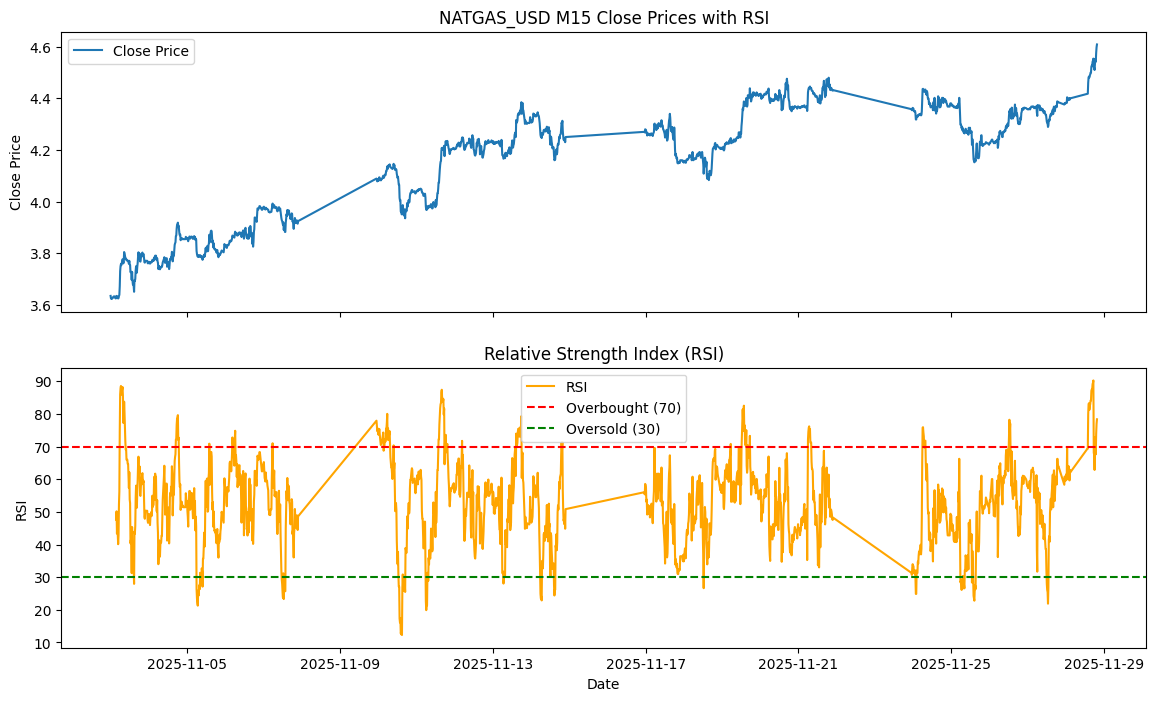

In [5]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot on top: Price
ax1.plot(new_data_df.index, new_data_df["close"], label="Close Price")

ax1.set_title("NATGAS_USD M15 Close Prices with RSI")
ax1.set_ylabel("Close Price")
ax1.legend()

# Plot on bottom: RSI
ax2.plot(new_data_df.index, new_data_df["RSI"], label="RSI", color="orange")
ax2.axhline(70, color="red", linestyle="--", label="Overbought (70)")
ax2.axhline(30, color="green", linestyle="--", label="Oversold (30)")
ax2.set_ylabel("RSI")
ax2.set_xlabel("Date")
ax2.set_title("Relative Strength Index (RSI)")
ax2.legend()

In [6]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Create subplots
# rows=2 and cols=1 mirrors your (ax1, ax2) structure.
# row_heights can be adjusted to make the price plot taller (e.g., 0.7 for the top, 0.3 for the bottom).
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("NATGAS_USD M15 Close Prices", "Relative Strength Index (RSI)"),
)

# 2. Add Price Plot (Top Subplot)
fig.add_trace(
    go.Scatter(
        x=new_data_df.index,
        y=new_data_df["close"],
        mode="lines",
        name="Close Price",
        line=dict(color="blue"),
    ),
    row=1,
    col=1,
)

# 3. Add RSI Plot (Bottom Subplot)
fig.add_trace(
    go.Scatter(
        x=new_data_df.index,
        y=new_data_df["RSI"],
        mode="lines",
        name="RSI",
        line=dict(color="orange"),
    ),
    row=2,
    col=1,
)

# Add Overbought (70) and Oversold (30) lines to the RSI subplot
fig.add_hline(
    y=70,
    line_dash="dash",
    line_color="red",
    annotation_text="Overbought (70)",
    annotation_position="top left",
    row=2,
    col=1,
)

fig.add_hline(
    y=30,
    line_dash="dash",
    line_color="green",
    annotation_text="Oversold (30)",
    annotation_position="bottom left",
    row=2,
    col=1,
)

# 4. Update Layout and Titles
fig.update_layout(
    title_text="NATGAS_USD M15 Close Prices with RSI (Interactive)",
    # Set height for the overall figure
    height=800,
    # Make the entire background white
    plot_bgcolor="white",
    # Enable pan/zoom and other interactive features
    hovermode="x unified",
)

# Update Y-axes titles
fig.update_yaxes(title_text="Close Price", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1)

# Update X-axis title (only needed for the bottom subplot since axes are shared)
fig.update_xaxes(title_text="Date", row=2, col=1)

# Enable gridlines on all x-axes and y-axes
fig.update_xaxes(showgrid=True, gridcolor="lightgray")
fig.update_yaxes(showgrid=True, gridcolor="lightgray")

# Add axis lines
fig.update_xaxes(showline=True, linewidth=1, linecolor="black", mirror=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", mirror=False)

# Display the figure
fig.show()

Examining the above it is clear that the RSI is not a clear cut strategy that will ensure profit every time. Though we see instances for example 4th of November 17:45 and 10th of November 18:45 where an oversold RSI indicator correctly identified a reversal. We also see that on the 11th of November 16:30 that the price of NATGAS displayed horizontal movement (neither up or down).

## Modeling RSI Strategy

To understand the effectivness of this strategy on NATGAS we utilise a backtesting library called backtrader. The complete strategy can be found within SRC -> strategies.py. A multitude of buy or sell orders are placed, dependent on whether the RSI is correspondingly above or below threshold. These positions are then closed out when their respective exit RSI values are reached (70 for buy and 30 for sell).

In [7]:
# Dataframe of candles are fed into in Backtrader
if new_data_df is not None:
    data_feed = bt.feeds.PandasData(dataname=new_data_df)

# --- Configuration Parameters ---
START_CASH = 100000.0
COMMISSION = 0.001  # 0.1% commission
LEVERAGE = 20
RSI_PERIOD = 14
BUY_LEVEL = 30
SELL_LEVEL = 70
STAKE_SIZE = 100  # Units of NATGAS

# =============================================================
# BACKTEST SETUP
# =============================================================
cerebro = bt.Cerebro()
cerebro.addstrategy(MultiOrderRSI)
cerebro.adddata(data_feed)

# Broker setup
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=COMMISSION, leverage=LEVERAGE)

# Run backtest
results = cerebro.run()
strat = results[0]

# Export closed positions to DataFrame
df = pd.DataFrame(strat.closed_positions)
df

SELL EXECUTED @ 3.6700 | RSI 86.01
SELL EXECUTED @ 3.7270 | RSI 87.89
SELL EXECUTED @ 3.7470 | RSI 88.58
SELL EXECUTED @ 3.7560 | RSI 85.93
SELL EXECUTED @ 3.7540 | RSI 86.78
SELL EXECUTED @ 3.7600 | RSI 87.59
SELL EXECUTED @ 3.7720 | RSI 88.27
SELL EXECUTED @ 3.7760 | RSI 85.40
SELL EXECUTED @ 3.7700 | RSI 77.27
SELL EXECUTED @ 3.7630 | RSI 78.38
SELL EXECUTED @ 3.7630 | RSI 83.77
SELL EXECUTED @ 3.8040 | RSI 80.36
SELL EXECUTED @ 3.7970 | RSI 75.93
SELL EXECUTED @ 3.7890 | RSI 71.67
SELL EXECUTED @ 3.7810 | RSI 69.06
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00
BUY EXECUTED @ 3.6510 | RSI 44.00

,type,entry_rsi,entry_price,entry_time,order_ref,exit_order,exit_rsi,exit_time,exit_price,pnl
0,short,74.662460,3.671,2025-11-03 05:45:00,Ref: 1\nOrdType: 1\nOrdType: Sell\nStatus: 4\n...,Ref: 17\nOrdType: 0\nOrdType: Buy\nStatus: 4\n...,27.949466,2025-11-03 14:45:00,3.650,0.021
1,short,86.007752,3.730,2025-11-03 06:00:00,Ref: 2\nOrdType: 1\nOrdType: Sell\nStatus: 4\n...,Ref: 18\nOrdType: 0\nOrdType: Buy\nStatus: 4\n...,27.949466,2025-11-03 14:45:00,3.650,0.080
2,short,87.888518,3.749,2025-11-03 06:15:00,Ref: 3\nOrdType: 1\nOrdType: Sell\nStatus: 4\n...,Ref: 19\nOrdType: 0\nOrdType: Buy\nStatus: 4\n...,27.949466,2025-11-03 14:45:00,3.650,0.099
3,short,88.584297,3.757,2025-11-03 06:30:00,Ref: 4\nOrdType: 1\nOrdType: Sell\nStatus: 4\n...,Ref: 20\nOrdType: 0\nOrdType: Buy\nStatus: 4\n...,27.949466,2025-11-03 14:45:00,3.650,0.107
4,short,85.926299,3.753,2025-11-03 06:45:00,Ref: 5\nOrdType: 1\nOrdType: Sell\nStatus: 4\n...,Ref: 21\nOrdType: 0\nOrdType: Buy\nStatus: 4\n...,27.949466,2025-11-03 14:45:00,3.650,0.103
...,...,...,...,...,...,...,...,...,...,...
208,long,27.922605,4.310,2025-11-27 12:00:00,Ref: 413\nOrdType: 0\nOrdType: Buy\nStatus: 4\...,Ref: 423\nOrdType: 1\nOrdType: Sell\nStatus: 4...,79.964226,2025-11-28 14:00:00,4.461,0.151
209,long,26.062797,4.304,2025-11-27 12:15:00,Ref: 418\nOrdType: 0\nOrdType: Buy\nStatus: 4\...,Ref: 424\nOrdType: 1\nOrdType: Sell\nStatus: 4...,79.964226,2025-11-28 14:00:00,4.461,0.157
210,long,25.454193,4.302,2025-11-27 12:30:00,Ref: 419\nOrdType: 0\nOrdType: Buy\nStatus: 4\...,Ref: 425\nOrdType: 1\nOrdType: Sell\nStatus: 4...,79.964226,2025-11-28 14:00:00,4.461,0.159
211,long,21.878010,4.289,2025-11-27 12:45:00,Ref: 420\nOrdType: 0\nOrdType: Buy\nStatus: 4\...,Ref: 426\nOrdType: 1\nOrdType: Sell\nStatus: 4...,79.964226,2025-11-28 14:00:00,4.461,0.172


# Evaluation

### 1.1 Cumulative Returns

In [8]:
df["Cumulative_return"] = df["pnl"].cumsum()

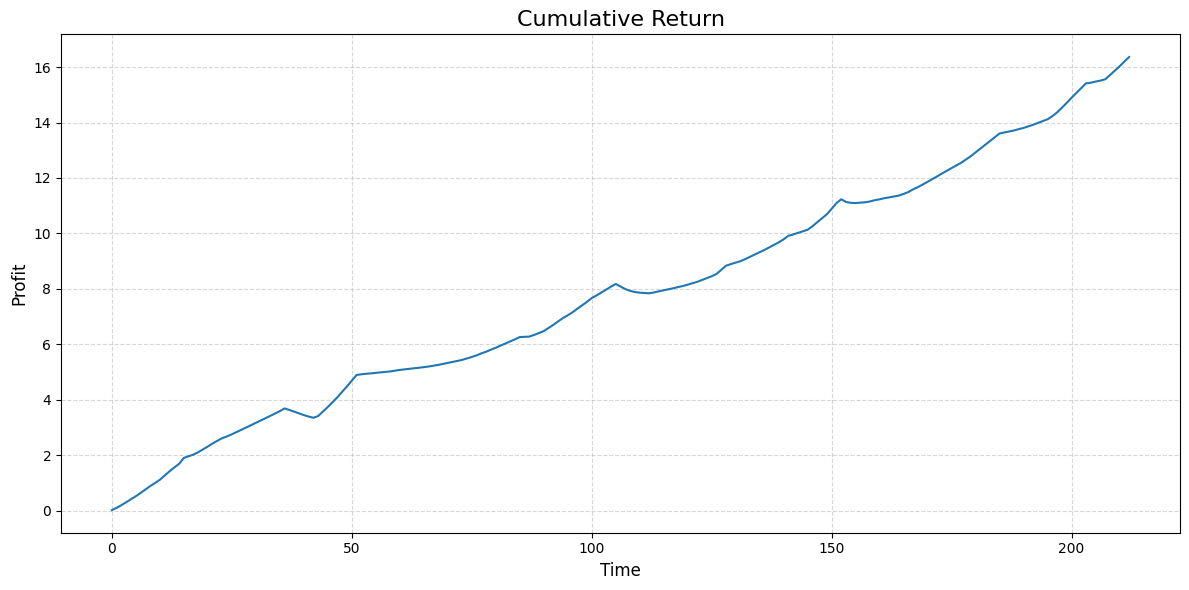

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df["Cumulative_return"])
plt.title("Cumulative Return", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Profit", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Evaluating the above curve, the strategy shows promising results with the cumulative pnl (equity_curve) increasing with time.

### Baseline Comparison

As a comparison if we take the difference between the difference between the first and last value we get the below. With a leverage of 20 we see that there is only a difference of 0.86p. We can therefore conclude that the profit made from this strategy is not necessarily more profitable than just buying and selling at the beginning of the period.

In [10]:
cumulative_profit = df["Cumulative_return"].iloc[-1]
last_value = new_data_df["close"].iloc[-1]
first_value = new_data_df["close"].iloc[0]
difference = last_value - first_value

cumulative_profit - difference * 20

np.float64(-3.135000000000005)

### 1.2 Sharpe Ratio

The Sharpe Ratio is the risk-adjusted return measure that indicates the average return earned in excess of the risk-free rate per unit of volatility or total risk. 

It is calculated using the following:

$$
\text{Sharpe Ratio} = \frac{E[R_p - R_f]}{\sigma_p}
$$

In [15]:
daily_returns_complete, annual_vol, annual_sharpe, mean_daily = compute_sharpe_metrics(
    df, START_CASH
)

print("Annualised Vol:", annual_vol)
print("Annualised Sharpe:", annual_sharpe)
print("Mean Daily Return:", mean_daily)
print("Daily Vol:", daily_returns_complete["pnl"].std())

Annualised Vol: 0.00012158894961682613
Annualised Sharpe: 9.755377915379315
Mean Daily Return: 6.29423076923077e-06
Daily Vol: 7.659383877611528e-06


The above calculated Sharpe ratio is questionable. A sharpe of 9-10, is exceptional performance and most probably due to error and calculations should be reviewed. Another potential reason is that Natural Gas for the time period studied fortunately performed exceptionally leading to a high Sharpe and should be checked against other periods. When computing the daily vol, days where no PnL was registered was taken into account and the correct way may be to only take trading days as weekends would also be included in my calculation.

## Conclusion

The main purpose of this study was to get an understanding of how the library BackTrader works but also to see whether the strategy could make profit. From this simple study it suggests that this can be possible however in future iterations of this study, I will need to conduct further investigation.

These studies include:
  - Use p-values to determine whether statisically significant (profit of strategy against baseline)
  - testing over many different time ranges or a long time range to understand if profit is possible
  - Utilising different timeframes. This study used a 15 minute study, comparing against 5, 10, 30 minutes and 1 hour timeframes will be interesting to understand how it compares.
  - Utilising more indicators such as Bollinger Bands combined with RSI and comparing returns against Simple RSI strategy.
  - Investigating teh Sharpe Ratio (current value seems wrong) and Drawdown
